In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Load Data

In [2]:
df = pd.read_excel('../data/burnside2.xls')
df.rename(columns={'GDPG':'GDP Growth', 
                   'BB':'Budget Surplus',
        'INFL':'Inflation', 'SACW':'Trade Openness', 
        'ETHNF':'Ethnic Frac', 'ASSAS':'Assassinations', 
        'ICRGE':'Institutional Quality', 'M2-1':'L_Money Supply', 'SSA':'Sub-Saharan Africa',
        'EASIA': 'East Asia', 'LPOP':'Log Population', 'EGYPT':'Egypt', 'CENTAM':'Central America', 
        'FRZ':'Franc Zone', 'ARMS-1':'L_Arms NX', 'EDA':'Effective Aid',
        'BEDA':'Bilateral Effective Aid'}, inplace=True)

# Create Groups

In [3]:
country_idx, countries = pd.factorize(df.Country)

# Mean Model

In [5]:
coords = {'country':countries}

with pm.Model(coords=coords) as unpooled:
    fixed_effect = pm.Normal('fixed_effect', mu=0, sigma=1, dims=['country'])
    mu = pm.Deterministic('mu', fixed_effect[country_idx])

    sigma = pm.Exponential('sigma', lam=1)
    gdp_hat = pm.Normal('gdp', mu=mu, sigma=sigma, observed=df['GDP Growth'])

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/pymc/model/core.py:1356: ImputationWarning: Data in gdp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


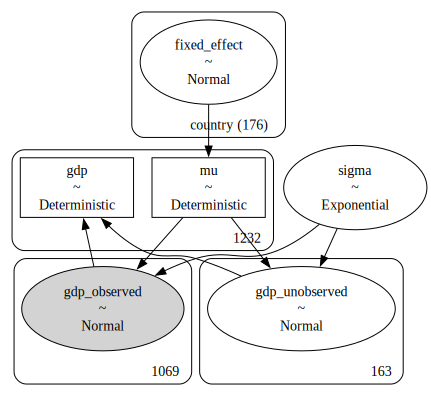

In [6]:
pm.model_to_graphviz(unpooled)

In [ ]:
with unpooled:
    idata = pm.sample(init='jitter+adapt_diag_grad')

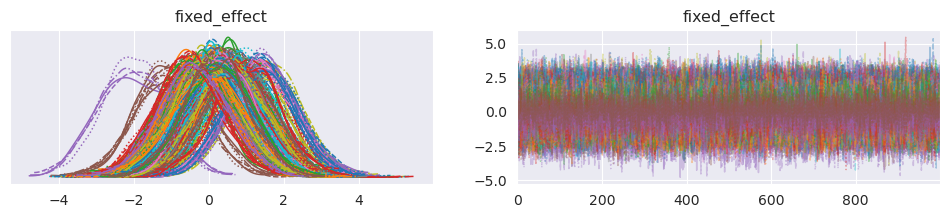

In [8]:
az.plot_trace(idata, var_names=['fixed_effect']);

In [9]:
with unpooled:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [gdp_observed]


Output()

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


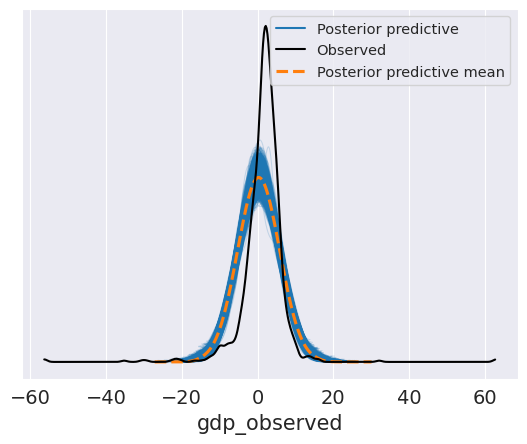

In [10]:
az.plot_ppc(idata);

# Partially Pooled

In [11]:
country_idx, countries = pd.factorize(df.Country3)
year_idx, years = pd.factorize(df.YEAR1)
coords = {
    'country':countries,
    'year':years
}

In [12]:
with pm.Model(coords=coords) as partially_pooled:
    country_effect_mu = pm.Normal('country_effect_mu', mu=0, sigma=1)
    country_effect_sigma = pm.HalfNormal('country_effect_sigma', sigma=1)
    country_effect_offset = pm.ZeroSumNormal('country_effect_offset', sigma=1, dims=['country'])
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_sigma * country_effect_offset,
                                    dims=['country'])

    # Add time effects
    time_effect = pm.Normal('time_effect', mu=0, sigma=1, dims=['year'])
    
    # Update mu
    mu = pm.Deterministic('mu', country_effect[country_idx] + time_effect[year_idx])
    sigma = pm.Exponential('sigma', lam=1)
    gdp_hat = pm.Normal('gdp', mu=mu, sigma=sigma, observed=df['GDP Growth'])

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/pymc/model/core.py:1356: ImputationWarning: Data in gdp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


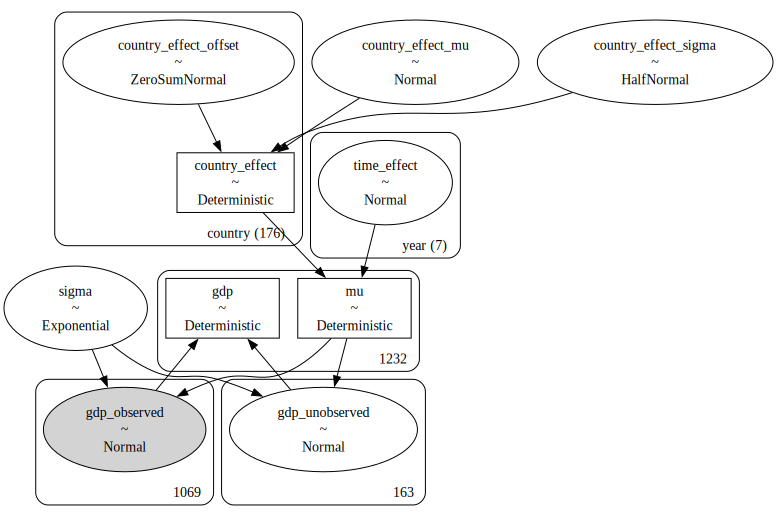

In [13]:
pm.model_to_graphviz(partially_pooled)

In [ ]:
with partially_pooled:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [country_effect_mu, country_effect_sigma, country_effect_offset, time_effect, sigma, gdp_unobserved]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [15]:
az.summary(idata, var_names=['time_effect'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
time_effect[1966-69],1.606,0.499,0.634,2.533,0.009,0.007,2788.0,2417.0,1.0
time_effect[1970-73],1.582,0.503,0.677,2.570,0.009,0.007,2823.0,3211.0,1.0
time_effect[1974-77],0.927,0.484,0.018,1.859,0.009,0.007,2741.0,2761.0,1.0
time_effect[1978-81],0.370,0.478,-0.571,1.227,0.010,0.007,2531.0,2704.0,1.0
time_effect[1982-85],-1.019,0.485,-1.883,-0.042,0.009,0.007,2704.0,2647.0,1.0
time_effect[1986-89],0.115,0.466,-0.756,0.996,0.009,0.007,2403.0,2779.0,1.0
time_effect[1990-93],-2.239,0.479,-3.128,-1.358,0.009,0.007,2694.0,2883.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

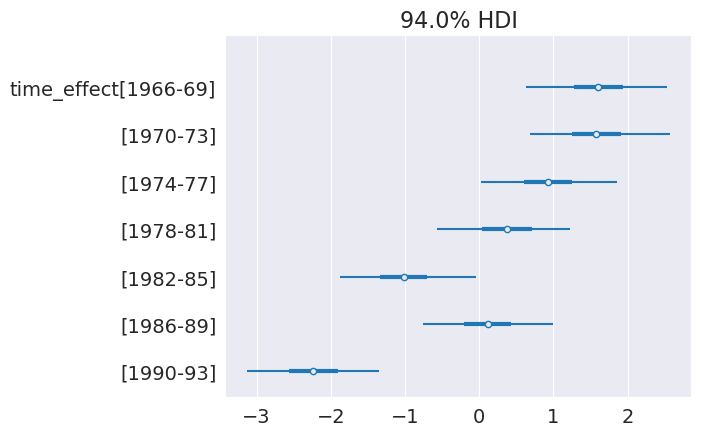

In [16]:
az.plot_forest(idata, var_names=['time_effect'], combined=True)

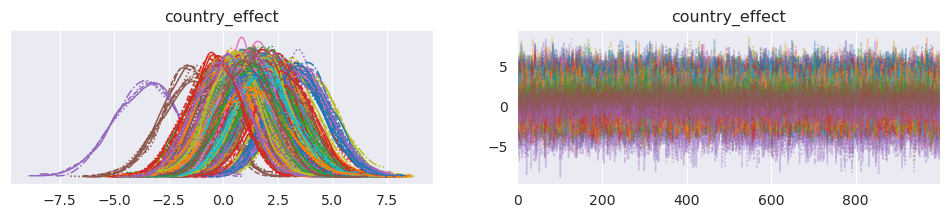

In [18]:
az.plot_trace(idata, var_names=['country_effect']);

In [19]:
with partially_pooled:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [gdp_observed]


Output()

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


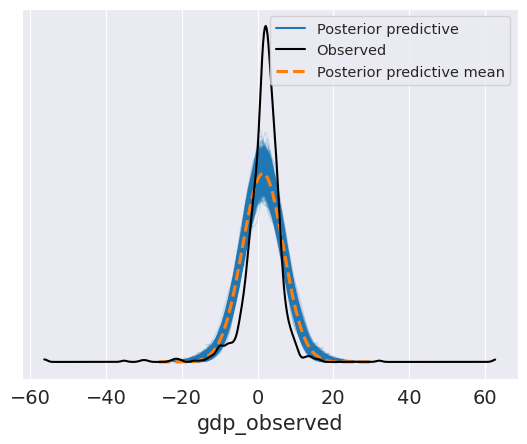

In [20]:
az.plot_ppc(idata);

In [22]:
factors = ['Inflation', 'Log Population', 'Effective Aid', 'Trade Openness']
labels = ['Year', 'Country3']
wdf = df[factors + labels + ['GDP Growth']].dropna(subset=factors)

obs_idx = wdf.index.values
country_idx, countries = pd.factorize(wdf.Country3)
year_idx, years = pd.factorize(wdf.Year)
coords = {
    'country':countries,
    'year':years,
    'factor':factors,
    'obs_idx':obs_idx
}

In [23]:
with pm.Model(coords=coords) as partially_pooled_w_regression:
    X = pm.MutableData('X', wdf[factors].apply(lambda x: (x - x.mean()) / x.std()), dims=['obs_idx', 'factor'])
    
    country_effect_mu = pm.Normal('country_effect_mu', mu=0, sigma=1)
    country_effect_sigma = pm.HalfNormal('country_effect_sigma', sigma=1)
    country_effect_offset = pm.ZeroSumNormal('country_effect_offset', sigma=1, dims=['country'])
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_sigma * country_effect_offset,
                                    dims=['country'])

    # Add time effects
    time_effect = pm.Normal('time_effect', mu=0, sigma=1, dims=['year'])

    # Add a regression
    beta_mu = pm.Normal('beta_mu', mu=0, sigma=1, dims=['factor'])
    beta_sigma = pm.HalfNormal('beta_sigma', sigma=1, dims=['factor'])
    beta_offset = pm.ZeroSumNormal('beta_offset', sigma=1, dims=['country', 'factor'])
    beta = pm.Deterministic('beta', beta_mu[None] + beta_sigma[None] * beta_offset, dims=['country', 'factor'])

    regression_effect = (X * beta[country_idx]).sum(axis=-1)
    
    mu = pm.Deterministic('mu', country_effect[country_idx] + time_effect[year_idx] + regression_effect, dims=['obs_idx'])
    sigma = pm.Exponential('sigma', lam=1)
    # nu = pm.Uniform('nu', 3, 30)
    gdp_hat = pm.StudentT('GDP Growth', mu=mu, sigma=sigma, nu=7, observed=wdf['GDP Growth'], dims=['obs_idx'])

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/pymc/model/core.py:1356: ImputationWarning: Data in GDP Growth contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [ ]:
with partially_pooled_w_regression:
    idata_reg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [country_effect_mu, country_effect_sigma, country_effect_offset, time_effect, beta_mu, beta_sigma, beta_offset, sigma, GDP Growth_unobserved]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains, 0 divergences ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  17% 0:00:23 / 0:00:06

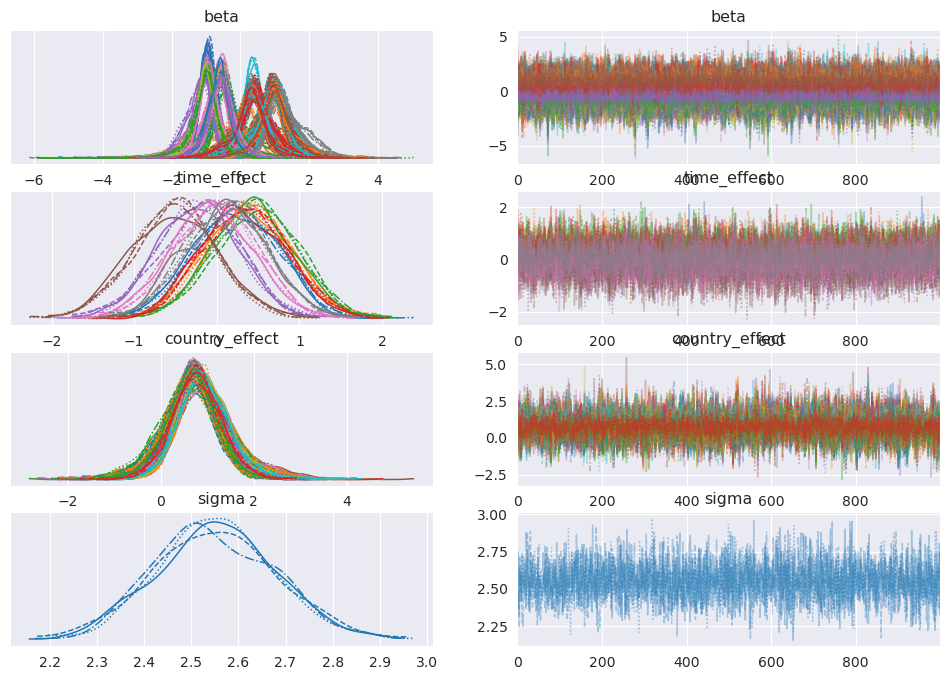

In [25]:
az.plot_trace(idata_reg, var_names=['beta', 'time_effect', 'country_effect', 'sigma']);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

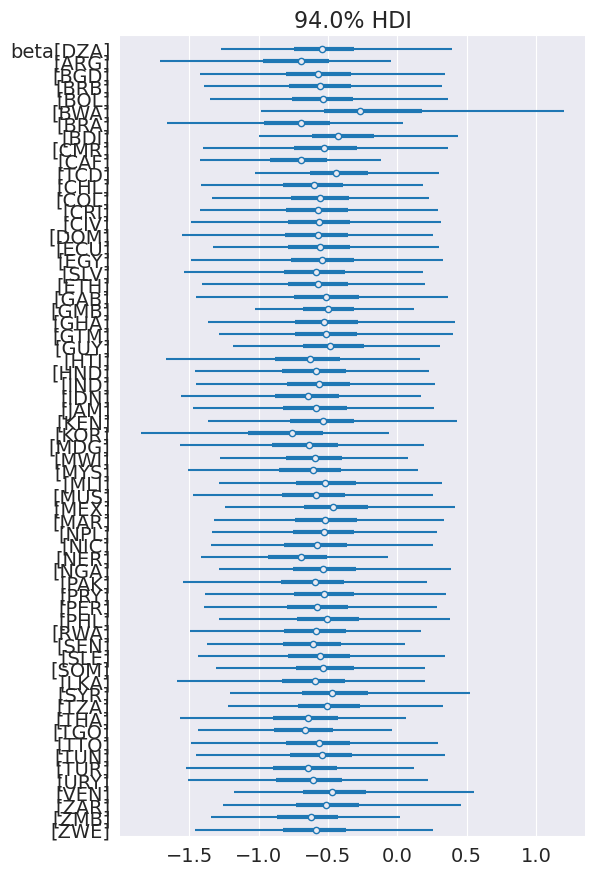

In [26]:
az.plot_forest(idata_reg, 
               var_names=['beta'], 
               coords={'factor':'Effective Aid'},
               combined=True)

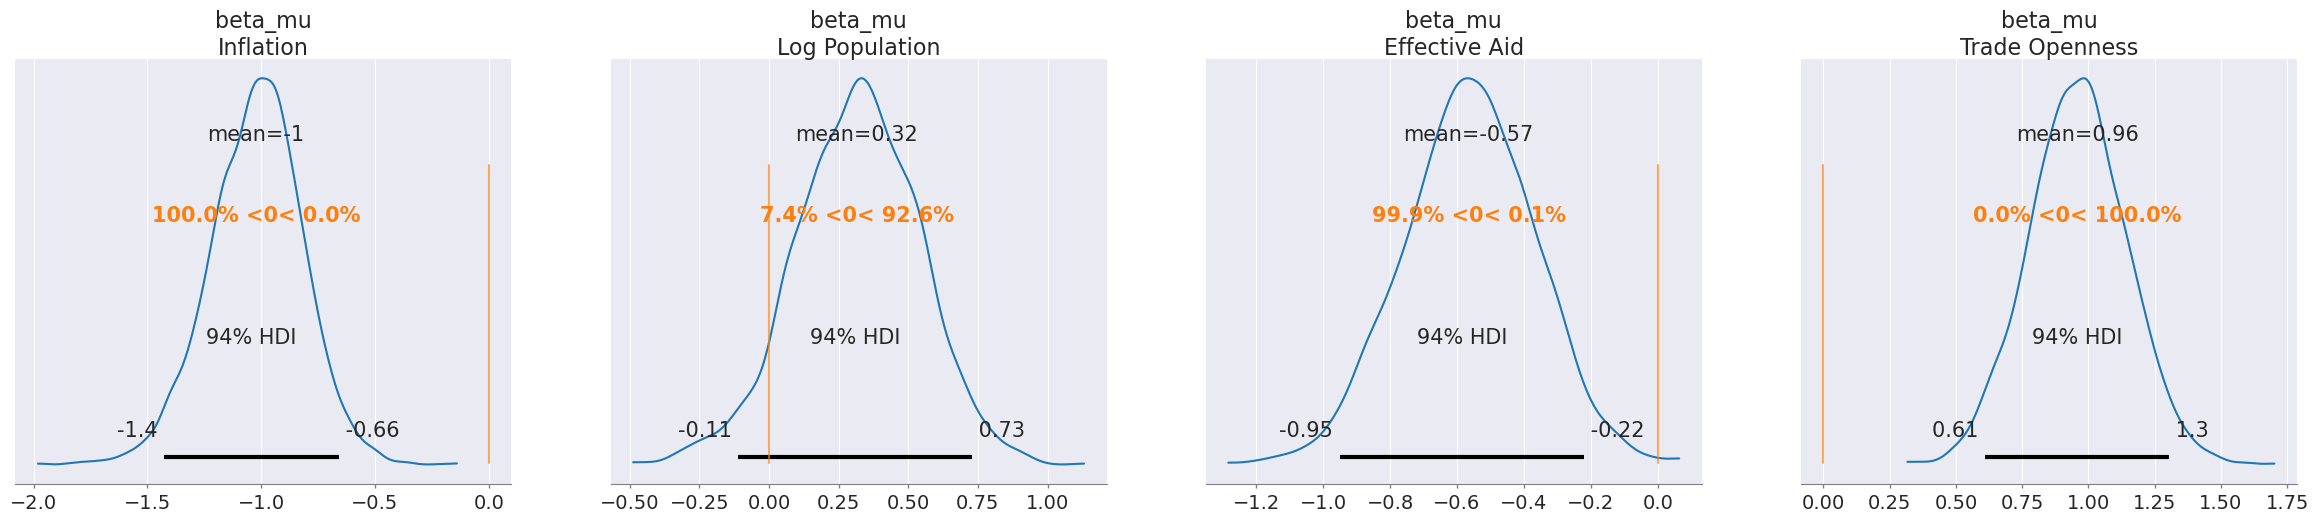

In [27]:
az.plot_posterior(idata_reg, var_names=['beta_mu'], ref_val=0);

In [28]:
with partially_pooled_w_regression:
    idata_reg = pm.sample_posterior_predictive(idata_reg, extend_inferencedata=True)

Sampling: [GDP Growth_observed]


Output()

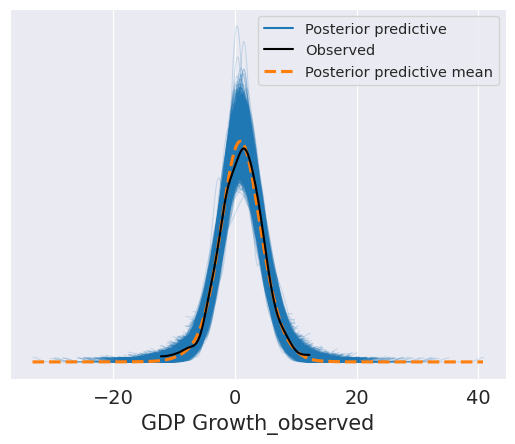

In [29]:
az.plot_ppc(idata_reg);

# Geography

In [31]:
import geopandas as geo
from libpysal.weights import Rook, Queen, KNN, fuzzy_contiguity
year_idx, years = pd.factorize(df.YEAR1)

gdf = geo.read_file('../data/WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp')
merged_df = pd.merge(gdf, df[df.YEAR1 == years[-1]], left_on='ISO_A3_EH', right_on='Country3')

In [32]:
A = fuzzy_contiguity(merged_df.geometry)
B = KNN.from_dataframe(merged_df, k=3)

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/libpysal/weights/util.py:1618: UserWarning: The weights matrix is not fully connected: 
 There are 46 disconnected components.
 There are 43 islands with ids: 6, 20, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173.
  return W(neighbors, **kwargs)
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [33]:
import networkx as nx
G = A.to_networkx()
H = B.to_networkx()

In [34]:
nx.adjacency_matrix(G).todense()

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

/tmp/ipykernel_250649/2653223122.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  .centroid


<Axes: xlabel='x', ylabel='y'>

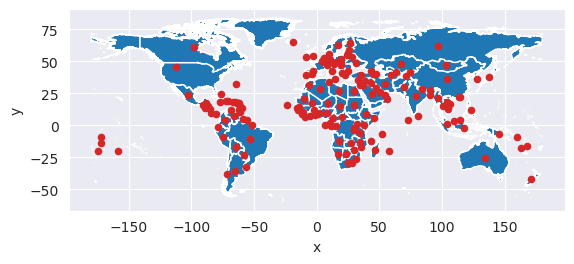

In [36]:
fig, ax = plt.subplots()
gdf.to_crs(4326).plot(ax=ax)
loc_df = (merged_df.to_crs(4326).geometry
     .centroid
     .apply(lambda row: pd.Series({'x':row.x, 'y':row.y})))

(loc_df.plot
     .scatter(x='x', y='y', ax=ax, color='tab:red'))

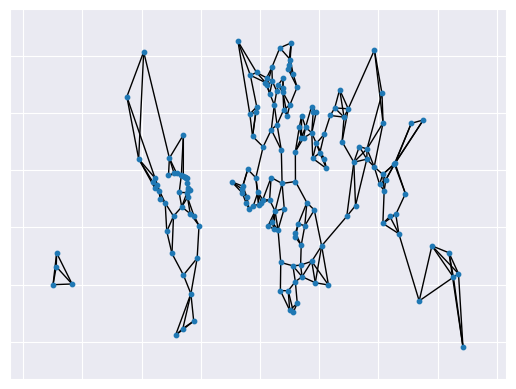

In [37]:
nx.draw_networkx(nx.to_undirected(H), node_size=10, with_labels=False, pos=loc_df.apply(lambda x: (x.x, x.y), axis=1).to_dict())

In [38]:
with pm.Model() as model:
    # Set priors on the hyperparameters of the covariance
    ls = pm.Gamma("ls1", alpha=2, beta=2)
    eta = pm.HalfNormal("eta", sigma=2)

    cov = pm.gp.cov.Matern52(2, ls=ls)  # cov_x1 must accept X1 without error

    # Specify the GP.  The default mean function is `Zero`.
    sigma = pm.Exponential('sigma', lam=1)
    gp = pm.gp.Marginal(cov_func=cov)
    gdp = gp.marginal_likelihood('gdp', X=loc_df.values, y=merged_df['GDP Growth'], sigma=sigma)
    idata = pm.sample()

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.12/site-packages/pymc/model/core.py:1356: ImputationWarning: Data in gdp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ls1, eta, sigma, gdp_unobserved]


Output()

ValueError: Not enough samples to build a trace.